In [18]:
! pip install openai pandas pydantic numpy pyarrow

Yelp Rating Prediction System (Using GPT-4o-mini with Concurrent Processing)
Loading dataset from data.parquet...
Saved 200 reviews to sampled_reviews.json

Evaluating: Approach 1: Direct Classification
Processing review 200/200...

Approach 1: Direct Classification Results:
- Processing Time: 42.15 seconds
- Accuracy: 10.00%
- JSON Validity Rate: 100.00%
- Mean Absolute Error: 1.14
- Predicted Distribution: {5: 46, 3: 34, 2: 41, 1: 43, 4: 36}
- Actual Distribution: {3: 39, 1: 46, 0: 42, 2: 39, 4: 34}
- Results saved to: results_approach1.json

Evaluating: Approach 2: Criteria-Based Analysis
Processing review 200/200...

Approach 2: Criteria-Based Analysis Results:
- Processing Time: 43.64 seconds
- Accuracy: 14.50%
- JSON Validity Rate: 100.00%
- Mean Absolute Error: 1.07
- Predicted Distribution: {4: 38, 2: 41, 3: 27, 1: 50, 5: 44}
- Actual Distribution: {3: 39, 1: 46, 0: 42, 2: 39, 4: 34}
- Results saved to: results_approach2.json

Evaluating: Approach 3: Few-Shot Learning
Processin

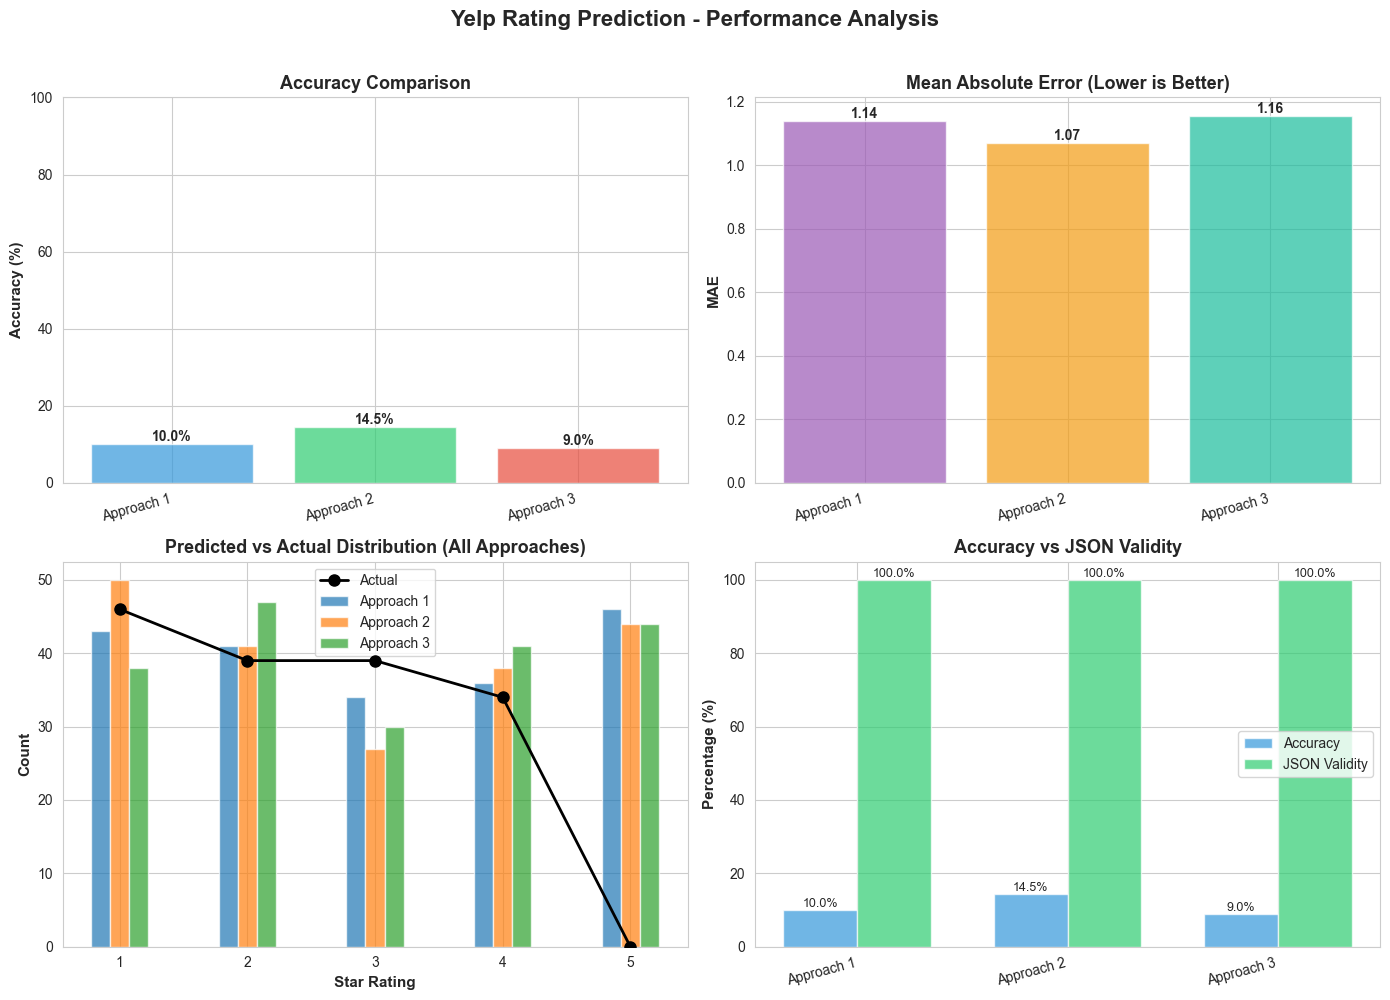

- sampled_reviews.json (input data)
- results_approach1.json
- results_approach2.json
- results_approach3.json
- evaluation_summary.json
- evaluation_results.png (performance charts)


In [ ]:
import pandas as pd
import json
from openai import OpenAI
from pydantic import BaseModel, Field
import time
from collections import Counter
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock
import matplotlib.pyplot as plt
import seaborn as sns

class RatingPrediction(BaseModel):
    predicted_stars: int = Field(description="Predicted rating from 1 to 5 stars", ge=1, le=5)
    explanation: str = Field(description="Brief reasoning for the assigned rating")

def sample_reviews(input_file='data.parquet', output_file='sampled_reviews.json', n_samples=200):
    print(f"Loading dataset from {input_file}...")
    df = pd.read_parquet(input_file)
    sampled_df = df.sample(n=min(n_samples, len(df)), random_state=42)
    reviews_data = []
    for idx, row in sampled_df.iterrows():
        reviews_data.append({
            "review_id": idx,
            "text": row['text'],
            "actual_score": int(row['label'])
        })
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(reviews_data, f, indent=2, ensure_ascii=False)
    
    print(f"Saved {len(reviews_data)} reviews to {output_file}")
    return reviews_data

PROMPT_APPROACH_1 = """You are a rating prediction expert. Analyze the following Yelp review and predict the star rating (1-5 stars).

Review: {review_text}

Consider:
- Overall sentiment (positive, neutral, negative)
- Specific praise or complaints
- Language intensity

Predict the rating between 1 (worst) to 5 (best) stars."""

PROMPT_APPROACH_2 = """You are a professional review analyst. Evaluate this Yelp review using these criteria:

Review: {review_text}

Analyze based on:
1. Quality: Overall quality of product/service/experience (excellent/poor/neutral)
2. Sentiment Indicators: Positive words (great, amazing, love) vs negative words (terrible, awful, hate)
3. Recommendation Likelihood: Would the reviewer recommend this to others?
4. Problem Severity: Are issues mentioned minor, major, or deal-breakers?

Based on this systematic analysis, predict the star rating (1-5):
- 5 stars: Exceptional, highly positive
- 4 stars: Good with minor issues
- 3 stars: Average, mixed feelings
- 2 stars: Below average, significant issues
- 1 star: Very poor experience"""

PROMPT_APPROACH_3 = """You are an expert at predicting Yelp ratings. Learn from these examples:

Example 1: "This is absolutely amazing! Best experience I've ever had. Everything was perfect." → 5 stars
Example 2: "Pretty good overall. Quality was decent but there were some minor issues." → 4 stars  
Example 3: "It was okay. Nothing special, nothing terrible. Average." → 3 stars
Example 4: "Disappointing. Poor quality and they seemed unprofessional." → 2 stars
Example 5: "Worst experience ever! Completely unacceptable. Never again!" → 1 star

Now predict the rating for this review:
Review: {review_text}

Consider the tone, specific details, and overall sentiment similar to the examples above."""

def predict_rating(review_text: str, prompt_template: str, client: OpenAI):
    try:
        prompt = prompt_template.format(review_text=review_text)
        completion = client.beta.chat.completions.parse(
            model="gpt-4o-mini", 
            messages=[
                {"role": "system", "content": "You are an expert at analyzing reviews and predicting ratings for any type of business or service."},
                {"role": "user", "content": prompt}
            ],
            response_format=RatingPrediction,
        )
        result = completion.choices[0].message.parsed
        
        return {
            "predicted_stars": result.predicted_stars,
            "explanation": result.explanation
        }
        
    except Exception as e:
        print(f"\nError predicting rating: {e}")
        return {"predicted_stars": 3, "explanation": f"Error: {str(e)}"}

def evaluate_approach(reviews_data, prompt_template, approach_name, output_file, client, max_workers=10):
    print(f"\n{'='*60}")
    print(f"Evaluating: {approach_name}")
    print(f"{'='*60}")
    
    results = []
    json_valid_count = 0
    correct_predictions = 0
    progress_lock = Lock()
    completed = [0]
    
    def process_review(review):
        prediction = predict_rating(review['text'], prompt_template, client)
        
        with progress_lock:
            completed[0] += 1
            print(f"Processing review {completed[0]}/{len(reviews_data)}...", end='\r')
        
        return {"review": review, "prediction": prediction}
    
    start_time = time.time()
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_review, review): review for review in reviews_data}
        for future in as_completed(futures):
            try:
                result_data = future.result()
                review = result_data['review']
                prediction = result_data['prediction']
                
                if prediction and 'predicted_stars' in prediction:
                    json_valid_count += 1
                    if prediction['predicted_stars'] == review['actual_score']:
                        correct_predictions += 1
                
                results.append({
                    "review_id": review['review_id'],
                    "review": review['text'],
                    "actual_score": review['actual_score'],
                    "predicted_score": prediction.get('predicted_stars', None),
                    "explanation": prediction.get('explanation', ''),
                    "is_correct": prediction.get('predicted_stars') == review['actual_score']
                })
                
            except Exception as e:
                print(f"\nError processing review: {e}")
    
    elapsed_time = time.time() - start_time
    results.sort(key=lambda x: x['review_id'])
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    
    accuracy = (correct_predictions / len(reviews_data)) * 100
    json_validity = (json_valid_count / len(reviews_data)) * 100
    
    valid_results = [r for r in results if r['predicted_score'] is not None]
    mae = np.mean([abs(r['actual_score'] - r['predicted_score']) for r in valid_results])
    
    predicted_distribution = Counter([r['predicted_score'] for r in valid_results])
    actual_distribution = Counter([r['actual_score'] for r in results])
    
    print(f"\n\n{approach_name} Results:")
    print(f"- Processing Time: {elapsed_time:.2f} seconds")
    print(f"- Accuracy: {accuracy:.2f}%")
    print(f"- JSON Validity Rate: {json_validity:.2f}%")
    print(f"- Mean Absolute Error: {mae:.2f}")
    print(f"- Predicted Distribution: {dict(predicted_distribution)}")
    print(f"- Actual Distribution: {dict(actual_distribution)}")
    print(f"- Results saved to: {output_file}")
    
    return {
        "approach": approach_name,
        "processing_time": elapsed_time,
        "accuracy": accuracy,
        "json_validity": json_validity,
        "mae": mae,
        "predicted_distribution": dict(predicted_distribution),
        "actual_distribution": dict(actual_distribution)
    }

def create_visualizations(all_metrics, output_dir='.'):
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    approaches = [m['approach'] for m in all_metrics]
    accuracies = [m['accuracy'] for m in all_metrics]
    maes = [m['mae'] for m in all_metrics]
    json_validities = [m['json_validity'] for m in all_metrics]
    
    # 1. Accuracy Comparison
    ax1 = axes[0, 0]
    bars1 = ax1.bar(range(len(approaches)), accuracies, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7)
    ax1.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
    ax1.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
    ax1.set_xticks(range(len(approaches)))
    ax1.set_xticklabels(['Approach 1', 'Approach 2', 'Approach 3'], rotation=15, ha='right')
    ax1.set_ylim(0, 100)
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{accuracies[i]:.1f}%',
                ha='center', va='bottom', fontweight='bold')
    
    # 2. Mean Absolute Error
    ax2 = axes[0, 1]
    bars2 = ax2.bar(range(len(approaches)), maes, color=['#9b59b6', '#f39c12', '#1abc9c'], alpha=0.7)
    ax2.set_ylabel('MAE', fontsize=11, fontweight='bold')
    ax2.set_title('Mean Absolute Error (Lower is Better)', fontsize=13, fontweight='bold')
    ax2.set_xticks(range(len(approaches)))
    ax2.set_xticklabels(['Approach 1', 'Approach 2', 'Approach 3'], rotation=15, ha='right')
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height, f'{maes[i]:.2f}',
                ha='center', va='bottom', fontweight='bold')
    
    # 3. Distribution Comparison (Combined)
    ax3 = axes[1, 0]
    x = np.arange(1, 6)
    width = 0.15
    
    for idx, metrics in enumerate(all_metrics):
        pred_dist = metrics['predicted_distribution']
        pred_vals = [pred_dist.get(i, 0) for i in range(1, 6)]
        offset = (idx - 1) * width
        ax3.bar(x + offset, pred_vals, width, label=f'Approach {idx+1}', alpha=0.7)
    
    actual_dist = all_metrics[0]['actual_distribution']
    actual_vals = [actual_dist.get(i, 0) for i in range(1, 6)]
    ax3.plot(x, actual_vals, 'ko-', linewidth=2, markersize=8, label='Actual', zorder=10)
    
    ax3.set_xlabel('Star Rating', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax3.set_title('Predicted vs Actual Distribution (All Approaches)', fontsize=13, fontweight='bold')
    ax3.set_xticks(x)
    ax3.legend()
    
    # 4. Accuracy vs JSON Validity
    ax4 = axes[1, 1]
    x_pos = np.arange(len(approaches))
    width = 0.35
    bars_acc = ax4.bar(x_pos - width/2, accuracies, width, label='Accuracy', alpha=0.7, color='#3498db')
    bars_json = ax4.bar(x_pos + width/2, json_validities, width, label='JSON Validity', alpha=0.7, color='#2ecc71')
    ax4.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
    ax4.set_title('Accuracy vs JSON Validity', fontsize=13, fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(['Approach 1', 'Approach 2', 'Approach 3'], rotation=15, ha='right')
    ax4.legend()
    ax4.set_ylim(0, 105)
    
    for bars in [bars_acc, bars_json]:
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Yelp Rating Prediction - Performance Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    output_path = f'{output_dir}/evaluation_results.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

def main():
    print("Yelp Rating Prediction System (Using GPT-4o-mini with Concurrent Processing)")
    print("="*60)
    
    API_KEY = "Your openai key"
    client = OpenAI(api_key=API_KEY)
    
    reviews_data = sample_reviews('data.parquet', 'sampled_reviews.json', n_samples=200)
    
    approaches = [
        (PROMPT_APPROACH_1, "Approach 1: Direct Classification", "results_approach1.json"),
        (PROMPT_APPROACH_2, "Approach 2: Criteria-Based Analysis", "results_approach2.json"),
        (PROMPT_APPROACH_3, "Approach 3: Few-Shot Learning", "results_approach3.json")
    ]
    
    all_metrics = []
    total_start_time = time.time()
    
    for prompt_template, approach_name, output_file in approaches:
        metrics = evaluate_approach(reviews_data, prompt_template, approach_name, output_file, client, max_workers=10)
        all_metrics.append(metrics)
    
    total_elapsed_time = time.time() - total_start_time
    
    with open('evaluation_summary.json', 'w', encoding='utf-8') as f:
        json.dump(all_metrics, f, indent=2)
    
    print("\n" + "="*60)
    print("FINAL COMPARISON")
    print("="*60)
    print(f"Total Processing Time: {total_elapsed_time:.2f} seconds")
    print(f"Estimated Cost: ~$0.06 (using GPT-4o-mini)")
    print()
    
    for metrics in all_metrics:
        print(f"\n{metrics['approach']}:")
        print(f"  Processing Time: {metrics['processing_time']:.2f}s")
        print(f"  Accuracy: {metrics['accuracy']:.2f}%")
        print(f"  JSON Validity: {metrics['json_validity']:.2f}%")
        print(f"  MAE: {metrics['mae']:.2f}")
    
    print("\n" + "="*60)
    print("VISUALIZATIONS...")
    print("="*60)
    
    create_visualizations(all_metrics)
    
    print("- sampled_reviews.json (input data)")
    print("- results_approach1.json")
    print("- results_approach2.json")
    print("- results_approach3.json")
    print("- evaluation_summary.json")
    print("- evaluation_results.png (performance charts)")

if __name__ == "__main__":
    main()